C:\Users\xmich\AppData\Local\Temp\ipykernel_28920\2983104557.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.time = pd.to_datetime(df.time)


lowerbound is  0        98.683501
1        98.679574
2        98.673034
3        98.665150
4        98.656837
           ...    
6499    102.702231
6500    102.707222
6501    102.712037
6502    102.733632
6503    102.742262
Name: price, Length: 6504, dtype: float64 upperbound is  0       102.113240
1       102.115991
2       102.120701
3       102.126420
4       102.131142
           ...    
6499    106.241961
6500    106.234058
6501    106.226390
6502    106.197500
6503    106.185897
Name: price, Length: 6504, dtype: float64


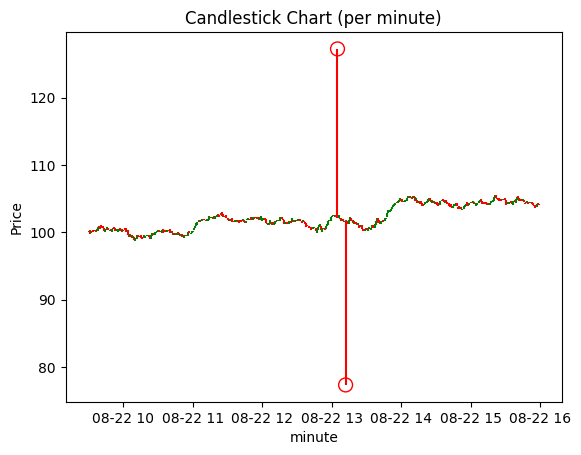

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def float_to_time(x):
    return str(int(x)) + ":" + str(int(x%1 * 60)).zfill(2) + ":" + str(int(x*60 % 1 * 60)).zfill(2)

def day_stock_data(with_outliers=True, outlier_prob=0.0005):
    # with_outliers: if True, generate outliers
    # outlier_prob: probability of generating an outlier
    #NYSE is open from 9:30 to 4:00
    time = 9.5
    price = 100
    results = [(float_to_time(time), price)]
    while time < 16:
        elapsed = np.random.exponential(.001)
        time += elapsed
        if time > 16:
            break
        price_diff = np.random.uniform(.999, 1.001)
        price *= price_diff

        # Add outlier value or stay with the current price
        if with_outliers and np.random.rand() < outlier_prob:
            jump = np.random.uniform(1.1, 1.3) if np.random.rand() < 0.5 else np.random.uniform(0.7, 0.9)
            jump_price = price * jump
            results.append((float_to_time(time), jump_price))

        else:
            results.append((float_to_time(time), price))
    
    
    df = pd.DataFrame(results, columns = ['time','price'])
    df.time = pd.to_datetime(df.time)
    return df
    
def candlestick(df, dt = "hour", outlier = "detect"):
    #df: dataframe with 'time' and 'price' columns
    #dt: "hour" or "minute"
    time = {"hour": df['time'].dt.hour,
            "minute": df['time'].dt.floor('min') }
    #width of bars regarding hour or minute graphs
    bar_width = {"hour": 0.8,
                 "minute": 0.0005}
    
    df['check_time'] = time[dt]

    #creating objects for dataframe without outliers and for only outliers values
    remove_outliers,detect_outliers = detect_outliers_iqr(df)
    if outlier == "detect":
        # circling outliers
        plt.scatter(detect_outliers["check_time"], detect_outliers["price"], label='Outliers',edgecolors = "red", facecolors = "none" , linewidths=1, s=100)
    elif outlier == "remove":
        # removing outliers from a dataframe
        df = remove_outliers
    else:
        raise ValueError("outlier parameter must be 'detect' or 'remove'")
    
    # min, max for each group
    minute_MM = df.groupby('check_time')['price'].agg(['min', 'max'])
    # first, last, height for each group
    minute_FL = df.groupby('check_time')['price'].agg(
        first='first',
        last='last',
        height=lambda x: x.iloc[-1] - x.iloc[0]
    )
    # Determine the color based on the height
    colors = np.where(minute_FL['height'] >= 0, 'green', 'red')
    # painting the candlestick chart
    plt.vlines(minute_MM.index, minute_MM['min'], minute_MM['max'], color=colors)
    plt.bar(minute_FL.index, minute_FL['height'], bottom=minute_FL['first'], color=colors, width=bar_width[dt])
    plt.xlabel(dt)  # name of X axis
    plt.ylabel("Price")  # name of Y axis
    plt.title("Candlestick Chart (per minute)")
"""
# That`s an alternative method using IQR without rolling window, I just don`t know what is better so I leave it here
def detect_outliers_iqr(df, factor=3):
    
    Q1 = df["price"].quantile(0.25)
    Q3 = df["price"].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df["price"] < Q1 - factor * IQR) | (df["price"] > Q3 + factor * IQR)
    
    return df[~mask],df[mask]
"""

def detect_outliers_iqr(df, factor=3, window=500):
    # rolling window IQR method to detect outliers
    prices = df["price"]
    Q1 = prices.rolling(window, center=True, min_periods = 1).quantile(0.25)
    Q3 = prices.rolling(window, center=True, min_periods = 1).quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    #print("lowerbound is ", lower_bound, "upperbound is ", upper_bound) 
    mask = (prices < lower_bound) | (prices > upper_bound)
    return df[~mask],df[mask]


def main():  
    df = day_stock_data()
    candlestick(df, "minute")

if __name__ == "__main__":
    main()